# Exemplo de Classificação Multiclasse com RNA (Dataset Wine)

Este notebook demonstra o uso da implementação de Rede Neural Artificial (RNA) para um problema de classificação com múltiplas classes, utilizando o dataset Wine da UCI.

## 1. Importação das Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import sys
import os

# Configurações de visualização
plt.style.use('ggplot')
%matplotlib inline

## 2. Importação da RNA Implementada

In [ ]:
import os
try:
    import google.colab
    IN_COLAB = True
    !git clone https://github.com/pedromandelli/RNA-Implementation.git
    %cd RNA-Implementation
    sys.path.insert(0, os.path.abspath(os.getcwd()))
except:
    IN_COLAB = False
    # Adicionar o diretório src ao PYTHONPATH se estiver executando localmente
    module_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    if module_path not in sys.path:
        sys.path.insert(0, module_path)


Ambiente local detectado. Ajustando o caminho do projeto...


In [3]:
from src.rna import NeuralNetwork
print("Importação da NeuralNetwork bem-sucedida.")


Importação da NeuralNetwork bem-sucedida.


## 3. Carregamento e Exploração dos Dados (Wine Dataset)

In [ ]:
# Carregar o conjunto de dados Wine
from sklearn.datasets import load_wine

wine = load_wine()
X = wine.data
y = wine.target.reshape(-1, 1)

df = pd.DataFrame(X, columns=wine.feature_names)
df['wine_class'] = pd.Categorical.from_codes(wine.target, wine.target_names)

print("Primeiras 5 linhas do conjunto de dados:")
df.head()

Primeiras 5 linhas do conjunto de dados:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


## 4. Pré-processamento dos Dados

In [ ]:
# Normalizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificar o target (y) para o formato One-Hot
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y)

print(f"Formato de X após scaling: {X_scaled.shape}")
print(f"Formato de y após one-hot encoding: {y_onehot.shape}")

Formato de X após scaling: (178, 13)
Formato de y após one-hot encoding: (178, 3)


In [ ]:
# Dividir os dados em treino (60%), validação (20%) e teste (20%) - seguindo a orientação do professor

# Primeiro, separar 20% dos dados para teste
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_onehot, test_size=0.20, random_state=42, stratify=y)

# Depois, separar 25% dos dados restantes para validação (25% de 80% = 20% do total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=np.argmax(y_temp, axis=1))

# Tamanhos
print(f"Tamanho treino: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.2f}%)")
print(f"Tamanho validação: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.2f}%)")
print(f"Tamanho teste: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]*100:.2f}%)")

# Distribuição de classes
print(f"Distribuição das classes em treinamento:\n{pd.Series(np.argmax(y_train, axis=1)).value_counts()}")
print(f"Distribuição das classes em validação:\n{pd.Series(np.argmax(y_val, axis=1)).value_counts()}")
print(f"Distribuição das classes em teste:\n{pd.Series(np.argmax(y_test, axis=1)).value_counts()}")

## 5. Criação e Treinamento do Modelo

In [ ]:
n_features = X_train.shape[1]
n_classes = y_train.shape[1]

model = NeuralNetwork(
    layer_sizes=[n_features, 10, 10, n_classes], # saída com o número de classes
    activation_functions=['relu', 'relu', 'softmax'] # softmax na saída
)

print("Arquitetura do modelo:")
print(model)

Arquitetura do modelo:
NeuralNetwork(layers=[13, 10, 10, 3], activation=['relu', 'relu', 'softmax'])


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=16,
    learning_rate=0.001,
    loss_function='categorical_crossentropy',
    optimizer='momentum',
    verbose=True,
    validation_data=(X_val, y_val)
)

Época 100/500 - loss: 0.0038
Época 200/500 - loss: 0.0013
Época 300/500 - loss: 0.0007
Época 400/500 - loss: 0.0005
Época 500/500 - loss: 0.0004


## 6. Avaliação do Modelo

In [ ]:
# Fazer predições no conjunto de teste
y_pred_proba = model.predict(X_test, output_activation='softmax')

# Converter as probabilidades em classes (o índice com maior probabilidade)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calcular a acurácia
accuracy = accuracy_score(y_test_classes, y_pred_classes)

print(f"Acurácia no conjunto de teste: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\nRelatório de Classificação:")
print(classification_report(y_test_classes, y_pred_classes, target_names=wine.target_names))

# Verificar se atende ao requisito do enunciado (erro < 50% -> acurácia > 50%)
print(f"O modelo {'atende' if accuracy > 0.5 else 'não atende'} ao requisito de desempenho.")

Acurácia no conjunto de teste: 0.9630 (96.30%)

Relatório de Classificação:
              precision    recall  f1-score   support

     class_0       0.95      1.00      0.97        18
     class_1       0.95      0.95      0.95        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54

O modelo atende ao requisito de desempenho.


## 7. Visualização dos Resultados

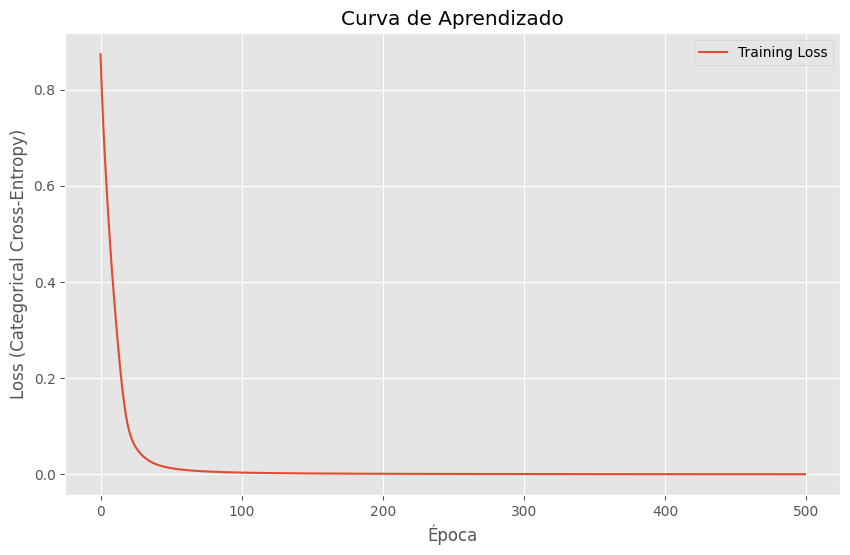

In [ ]:
# Visualizar a curva de aprendizado
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Curva de Aprendizado')
plt.xlabel('Época')
plt.ylabel('Loss (Categorical Cross-Entropy)')
plt.legend()
plt.show()

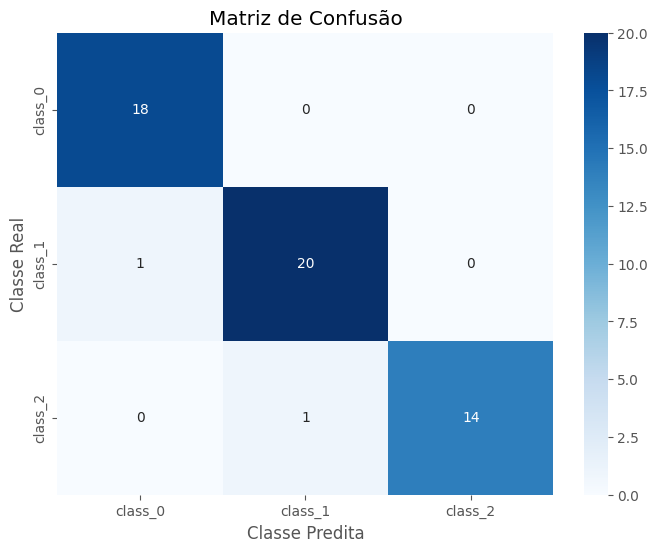

In [ ]:
# Visualizar a Matriz de Confusão
cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=wine.target_names, yticklabels=wine.target_names)
plt.title('Matriz de Confusão')
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.show()

## 8. Conclusão

Neste notebook, demonstramos o uso da nossa implementação de RNA para um problema de classificação multiclasse, utilizando o dataset Wine. O modelo foi capaz de aprender a distinguir entre os diferentes tipos de vinho com alta acurácia, atendendo aos requisitos do projeto.